Some of the G140m files have the wrong (not re-extracted) spectra in them

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
from astropy.convolution import convolve, Box1DKernel
from scipy.interpolate import interp1d



import astropy.units as u
from astropy import time, coordinates as coord
import astropy.constants as const
from astropy.modeling import models, fitting



#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [6]:
path = '/media/david/2tb_ext_hd/hddata/mega_muscles/v10_hlsp/'

stars = os.listdir(path)
stars

['GJ1132',
 'GJ15A',
 'GJ163',
 'GJ649',
 'GJ674',
 'GJ676A',
 'GJ699',
 'GJ729',
 'GJ849',
 'L-980-5',
 'LHS-2686',
 'TRAPPIST-1']

GJ1132


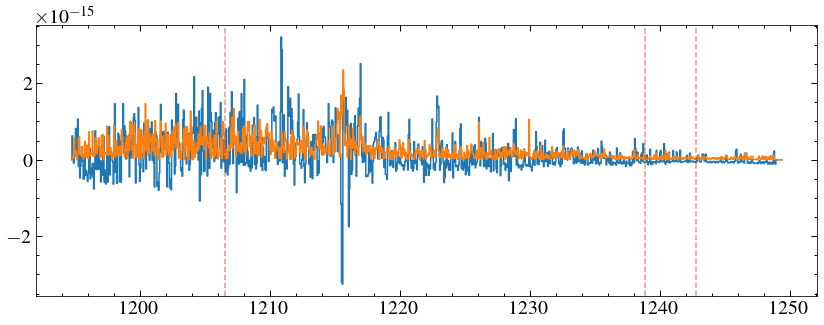

GJ15A
GJ163


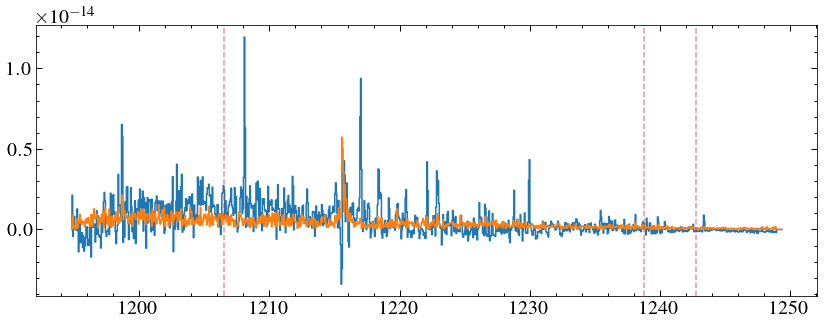

GJ649


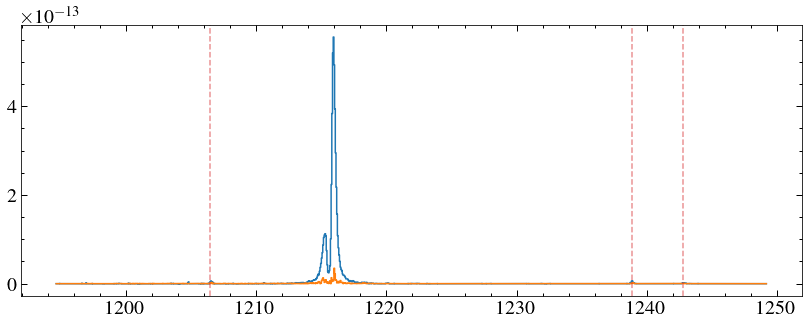

GJ674


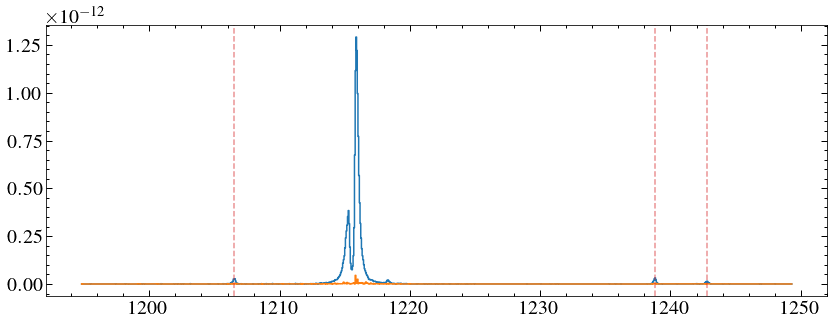

GJ676A


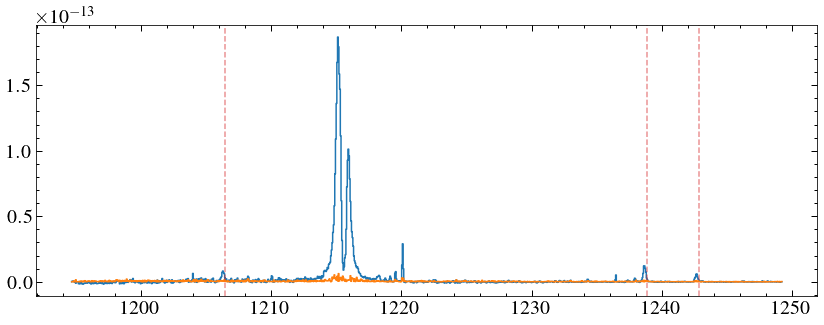

GJ699


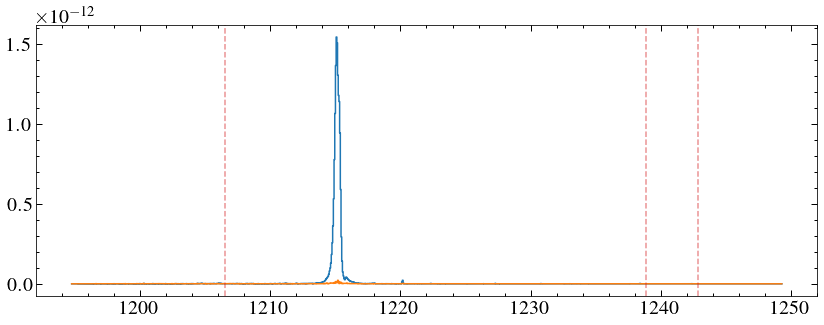

GJ729
GJ849


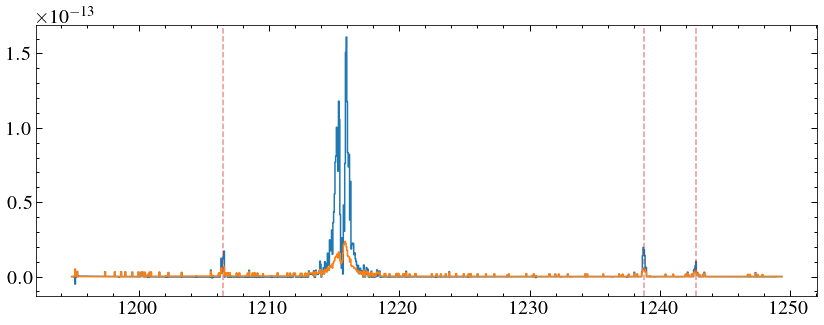

L-980-5


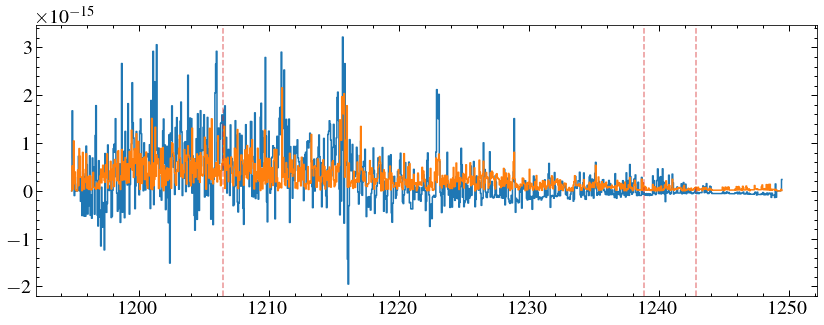

LHS-2686


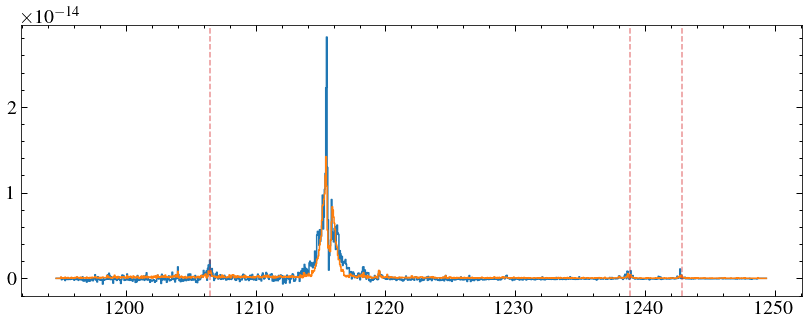

TRAPPIST-1


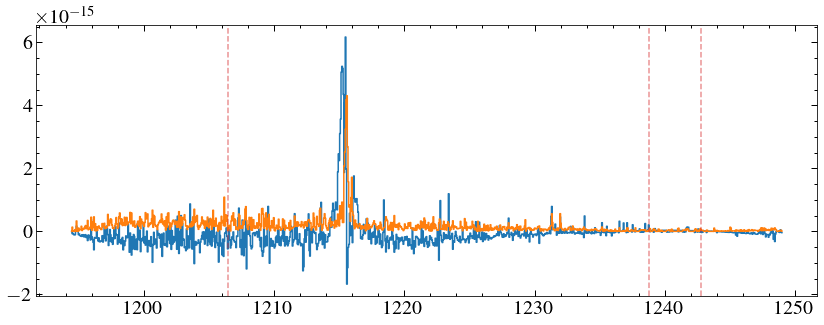

In [10]:
lines = [1206.499, 1238.821,1242.804]
for star in stars:
    print(star)
    fuv = glob.glob('{}{}/*g140m*'.format(path, star))
    # if len(fuv) == 0:
    #     fuv = glob.glob('{}{}/*e140m*'.format(path, star))
    if len(fuv) == 0:
        continue
    # nuv = glob.glob('{}{}/*g230l*'.format(path, star))
    
    fdata = fits.getdata(fuv[0], 1)
    fw, ff, fe = fdata['WAVELENGTH'], fdata['FLUX'], fdata['ERROR']
    
    # mask = (fw < 1210) | (fw > 1220) #mask lya
    
    # fw, ff, fe = fw[mask], ff[mask], fe[mask]
    
    # smooth = 2
    # ff = convolve(ff,Box1DKernel(smooth))
    # fe = convolve(fe,Box1DKernel(smooth))/(smooth**0.5)
    
    
    plt.step(fw, ff, where='mid')
    plt.step(fw, fe, where='mid')
    
    [plt.axvline(line, ls='--', c='C3', alpha=0.5) for line in lines]
    
    plt.show()

GJ1132, GJ163, L-980-5 and 1xLHS-2686 all had re-extractions. L980-5 is a non-detection.

In [11]:
print(stars)

['GJ1132', 'GJ15A', 'GJ163', 'GJ649', 'GJ674', 'GJ676A', 'GJ699', 'GJ729', 'GJ849', 'L-980-5', 'LHS-2686', 'TRAPPIST-1']


GJ1132


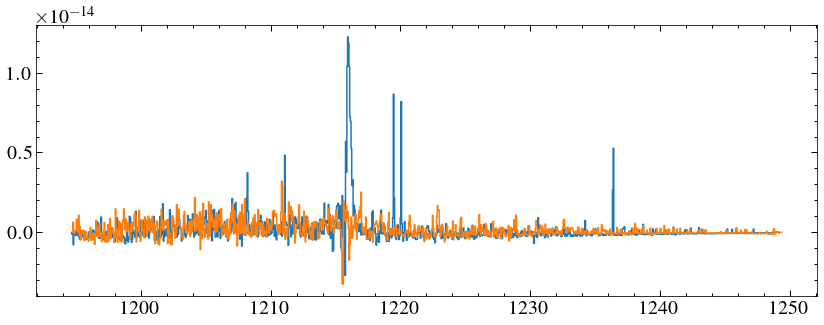

GJ163


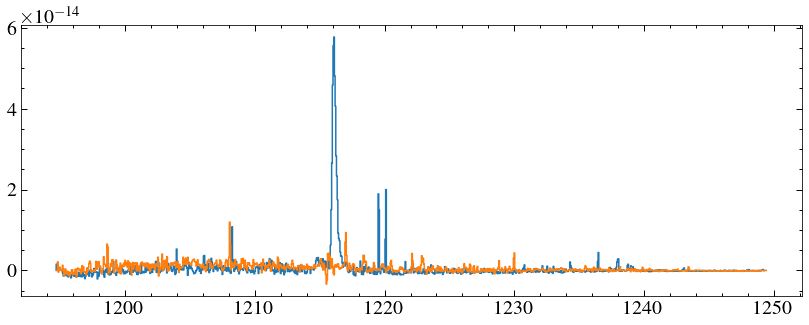

LHS-2686


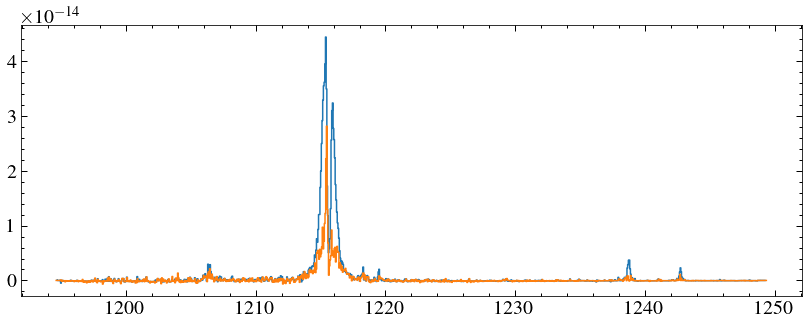

In [15]:
rex = ['GJ1132', 'GJ163', 'LHS-2686']

for star in rex:
    print(star)
    newspec = Table.read('../lya/coadds/{}_g140m_coadd_v1.ecsv'.format(star))
    plt.step(newspec['WAVELENGTH'], newspec['FLUX'])
    
    fuv = glob.glob('{}{}/*g140m*'.format(path, star))
  
    fdata = fits.getdata(fuv[0], 1)
    fw, ff, fe = fdata['WAVELENGTH'], fdata['FLUX'], fdata['ERROR']
    
    # mask = (fw < 1210) | (fw > 1220) #mask lya
    
    # fw, ff, fe = fw[mask], ff[mask], fe[mask]
    
    # smooth = 2
    # ff = convolve(ff,Box1DKernel(smooth))
    # fe = convolve(fe,Box1DKernel(smooth))/(smooth**0.5)
    
    
    plt.step(fw, ff, where='mid')

    
    
    plt.show()
    
    

Oops. Rextractions are on the old laptop :( .

In [17]:
path2 = '/media/david/2tb_ext_hd/hddata/mega_muscles/data/g140m/' #path where the g140m files from MAST are

In [38]:
def build_trace_grid(SPTRCTAB, grating, cenwave):
    """
    Extends a grid of trace displacements to cover all y positions
    """
    data = fits.getdata(SPTRCTAB, 1)
    tracedata = data[(data['OPT_ELEM']==grating) & (data['CENWAVE'] == cenwave)]
    all_y = np.arange(len(tracedata[0]['A2DISPL']))
    grid = interp1d(tracedata['A2CENTER'], tracedata['A2DISPL'], axis=0, fill_value='extrapolate')(all_y)
    tracegrid = [a+b for a, b in zip(grid, all_y)] 
    return tracegrid
    
def get_a2center(x, y, tracegrid):
    """
    get the trace a2center at a1center
    """
    xcol = np.array(tracegrid)[:,int(x)]
    xind = (np.abs(xcol - y)).argmin()
    a2center = xind + 1 #calstis is 1-indexed 
    return a2center

In [39]:
import stistools
os.environ['oref'] = path2

In [44]:
centab = Table.read('../lya/lya_trace_centers.ecsv')
for star in rex:
    print(star)
    for i, root in enumerate(centab['ROOTNAME']):
        flt = '{}{}_flt.fits'.format(path2, root)
        targ = fits.getheader(flt, 0)['TARGNAME']
        if targ == star:
            SPTRCTAB = fits.getheader(flt,0)['SPTRCTAB']
            grating = fits.getheader(flt,0)['OPT_ELEM']
            cenwave = fits.getheader(flt,0)['CENWAVE']
            tracegrid = build_trace_grid(path2+SPTRCTAB[5:], grating, cenwave)
            rootname = fits.getheader(flt)['ROOTNAME'] 
            print(rootname)
            outname = 'new_extractions/{}/{}_new_x1d.fits'.format(star, rootname)
            if os.path.exists(outname):
                os.remove(outname)
                
            x = centab['XCOL'][i]
            y = centab['A2CENTER'][i]
            a2center = get_a2center(x, y, tracegrid)
            print(a2center)
            stistools.x1d.x1d(flt, output = outname, trailer='new_extractions/{}/{}_new.trl'.format(star, rootname), 
                              a2center=a2center, maxsrch=5, bk1offst=-30, bk2offst=30)
                           
            print(fits.getdata(outname,1)['A2CENTER'])
            
    

GJ1132
odlm03040
391
[389.96774]
odlm03050
392
[389.6246]
GJ163
odlm15030
384
[384.88074]
odlm15040
385
[384.3111]
odlm15050
384
[384.3752]
LHS-2686
odlm34030
384
[383.98822]
odlm34040
384
[384.19495]
odlm35030
382
[383.8239]
odlm35040
383
[383.8304]


new_extractions/GJ1132/odlm03040_new_x1d.fits
new_extractions/GJ1132/odlm03050_new_x1d.fits


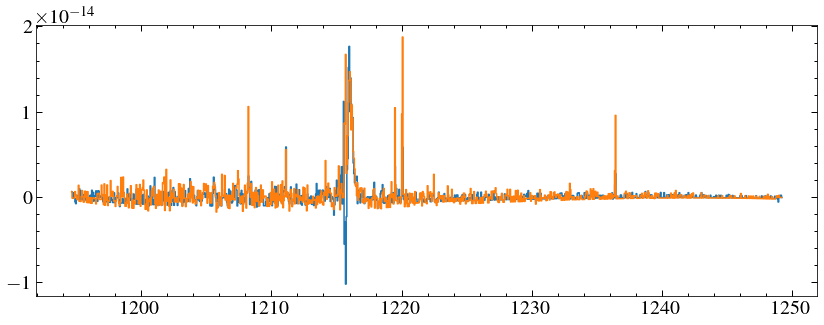

new_extractions/GJ163/odlm15040_new_x1d.fits
new_extractions/GJ163/odlm15050_new_x1d.fits
new_extractions/GJ163/odlm15030_new_x1d.fits


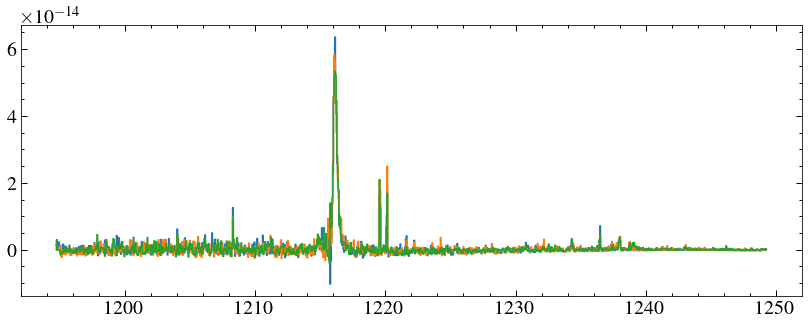

new_extractions/LHS-2686/odlm34040_new_x1d.fits
new_extractions/LHS-2686/odlm34030_new_x1d.fits
new_extractions/LHS-2686/odlm35030_new_x1d.fits
new_extractions/LHS-2686/odlm35040_new_x1d.fits


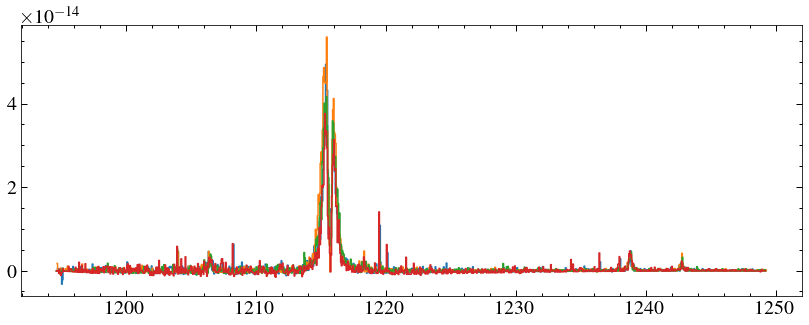

In [45]:
for star in rex:
    x1ds = glob.glob('new_extractions/{}/*x1d*'.format(star))
    for x in x1ds:
        print(x)
        grating = fits.getheader(x, 0)['OPT_ELEM'] 
        # print(grating)
        data = fits.getdata(x, 1)[0]
        # print(data['A2Center'])
        w, f, e, dq= data['WAVELENGTH'], data['FLUX'], data['ERROR'], data['DQ']
        if grating in ['G140M', 'G140L']:
            mask = (w > 1160) & (w < 1210) | (w > 1220)
        # if grating =='G230L':
            # mask = (w > 1700) 
        # if grating =='G430L':
            # mask = (w > 3000)

        # w, f, e = w[mask], f[mask], e[mask]
        # plt.ylim(-1e-16, 1e-16)
        # plt.axhline(0, ls='--', c='0.5')
        # plt.xlim(1200, 1230)

        plt.step(w, f, where='mid')
        # plt.ylim(-1, 30)
        # plt.step(w, e, where='mid')
    plt.show()



Good. Now turn them into hlsp.

In [46]:
import prepare_stis

/home/david/work/muscles/SEDs/common/prepare_stis.py:31: RuntimeWarning: divide by zero encountered in divide
  weights = 1 / (e_array**2)
/home/david/anaconda3/envs/stenv-py3.9-2022.08.08-latest/lib/python3.10/site-packages/numpy/lib/function_base.py:550: RuntimeWarning: invalid value encountered in multiply
  avg = np.multiply(a, wgt,


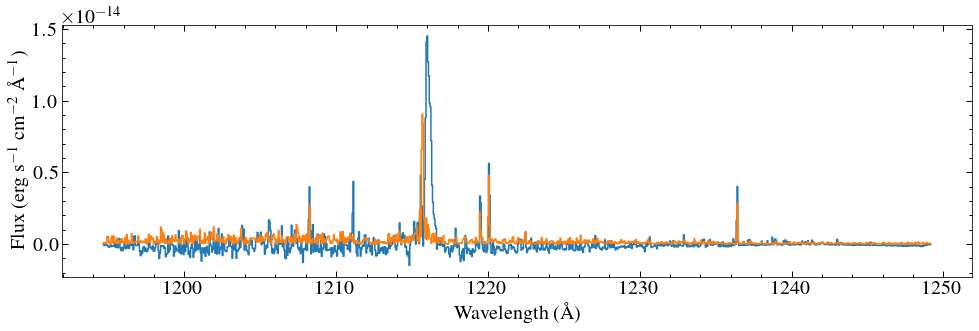

Spectrum saved as hlsp_muscles_hst_stis_gj1132_g140m_v23_component-spec.fits


/home/david/work/muscles/SEDs/common/prepare_stis.py:31: RuntimeWarning: divide by zero encountered in divide
  weights = 1 / (e_array**2)
/home/david/anaconda3/envs/stenv-py3.9-2022.08.08-latest/lib/python3.10/site-packages/numpy/lib/function_base.py:550: RuntimeWarning: invalid value encountered in multiply
  avg = np.multiply(a, wgt,


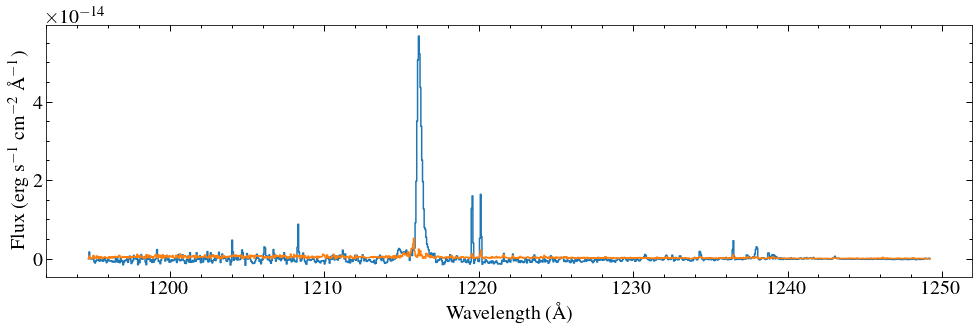

Spectrum saved as hlsp_muscles_hst_stis_gj163_g140m_v23_component-spec.fits


/home/david/work/muscles/SEDs/common/prepare_stis.py:31: RuntimeWarning: divide by zero encountered in divide
  weights = 1 / (e_array**2)
/home/david/anaconda3/envs/stenv-py3.9-2022.08.08-latest/lib/python3.10/site-packages/numpy/lib/function_base.py:550: RuntimeWarning: invalid value encountered in multiply
  avg = np.multiply(a, wgt,


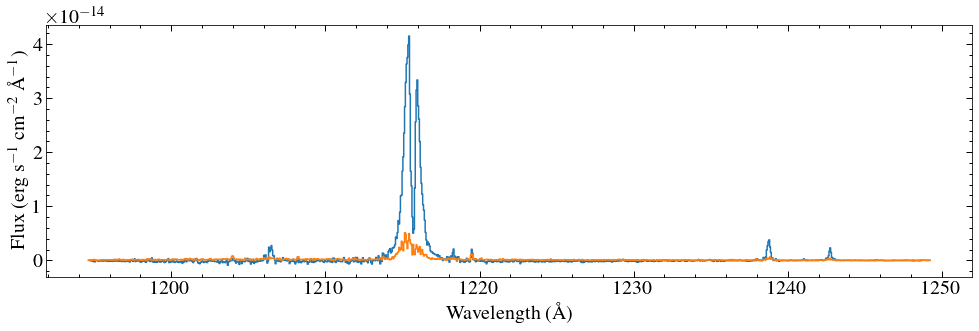

Spectrum saved as hlsp_muscles_hst_stis_lhs-2686_g140m_v23_component-spec.fits


In [48]:
for star in rex:
    prepare_stis.make_stis_spectum('new_extractions/{}/'.format(star), 23, savepath = 'new_extractions/updated_hlsp/', plot=True, save_ecsv=False, save_fits=True)